# Analysing mybinder.org launches

The first few cells download and massage the data. Later on we answer questions on which repositories are popular and such.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import datetime

import pandas as pd

In [2]:
index = pd.read_json("https://archive.analytics.mybinder.org/index.jsonl",
                     lines=True)

In [3]:
# get all days since start of 2019
now = datetime.datetime.now()
n = (now - datetime.datetime(2019, 1, 1)).days

# small range for previewing
n = 10

frames = []
for idx, day in index.sort_index(ascending=False).iterrows():
    df = pd.read_json("https://archive.analytics.mybinder.org/{}".format(day['name']),
                      lines=True, )
    frames.append(df)
    if len(frames) > n:
        break
        
print(f"Fetched data for {n} days.")

Fetched data for 10 days.


In [4]:
df = pd.concat(frames)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
# make it easier to grab the ref
def get_repo(spec):
    s = spec.rsplit("/", 1)[0]
    if s.endswith('.git'):
        s = s[:-4]
    return s
df['repo'] = df['spec'].apply(get_repo) #lambda s: s.rsplit("/", 1)[0].replace(".git", ""))
df['org'] = df['spec'].apply(lambda s: s.split("/", 1)[0])
df['ref'] = df['spec'].apply(lambda s: s.rsplit("/", 1)[1])

In [6]:
# take a look at the data, does it look sensible?
df.sample(10)

,origin,provider,schema,spec,status,timestamp,version,repo,org,ref
1340,NaN,GitHub,binderhub.jupyter.org/launch,bokeh/bokeh-notebooks/master,success,2019-06-12 03:59:00,2,bokeh/bokeh-notebooks,bokeh,master
2809,gke.mybinder.org,GitLab,binderhub.jupyter.org/launch,rruizz%2Finforfis/master,success,2019-06-15 11:34:00,3,rruizz%2Finforfis,rruizz%2Finforfis,master
1977,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-18 05:23:00,3,ipython/ipython-in-depth,ipython,master
8399,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-13 12:21:00,3,ipython/ipython-in-depth,ipython,master
164,NaN,GitHub,binderhub.jupyter.org/launch,ines/spacy-io-binder/live,success,2019-06-12 00:32:00,2,ines/spacy-io-binder,ines,live
11909,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-12 17:36:00,2,ipython/ipython-in-depth,ipython,master
5491,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-12 09:53:00,2,ipython/ipython-in-depth,ipython,master
6867,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-14 13:05:00,3,ipython/ipython-in-depth,ipython,master
13356,ovh.mybinder.org,GitHub,binderhub.jupyter.org/launch,jupyterlab/jupyterlab-demo/master,success,2019-06-13 18:28:00,3,jupyterlab/jupyterlab-demo,jupyterlab,master
3274,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-20 06:27:00,3,ipython/ipython-in-depth,ipython,master


In [7]:
df = df.drop(columns=['schema', 'version', 'spec', 'status'])

In [8]:
df.head()

,origin,provider,timestamp,repo,org,ref
0,gke.mybinder.org,GitHub,2019-06-20,ipython/ipython-in-depth,ipython,master
1,gke.mybinder.org,GitHub,2019-06-20,ipython/ipython-in-depth,ipython,master
2,gke.mybinder.org,GitHub,2019-06-20,anniechen0127/lab-project,anniechen0127,master
3,gke.mybinder.org,GitHub,2019-06-20,rationalmatter/juno-demo-notebooks,rationalmatter,master
4,gke.mybinder.org,GitHub,2019-06-20,ipython/ipython-in-depth,ipython,master


In [9]:
df_ = df.set_index("timestamp")

In [10]:
def n_active_repos(period=30):
    """Unique active repos over the period
    
    With period=30 this gives monthly active repos
    With period=1 you get daily active repos
    """
    now = datetime.datetime.now()
    start = datetime.datetime(2019, 1, 1)
    days_since_start = (now - start).days

    data = []

    for n in range(days_since_start):
        s = start + datetime.timedelta(days=n)
        e = start + datetime.timedelta(days=n+period)
        if e > now:
            break

        # our "monthly" data
        monthly = df_.loc[s.isoformat():e.isoformat()]
        data.append(dict(timestamp=e, repos=len(set(monthly.repo))))
        
    return pd.DataFrame.from_records(data).set_index("timestamp")

In [11]:
monthly_active = n_active_repos(30)
weekly_active = n_active_repos(7)
daily_active = n_active_repos(1)

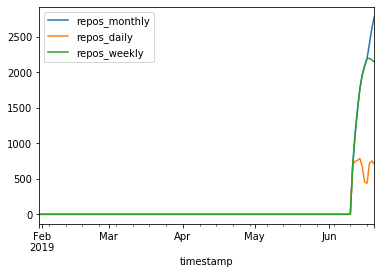

In [12]:
activity = pd.merge(monthly_active, daily_active,
                    suffixes=("_monthly", "_daily"), left_index=True, right_index=True)
activity = pd.merge(activity, weekly_active, left_index=True, right_index=True)

activity.columns = ['repos_monthly', 'repos_daily', 'repos_weekly']
activity.plot();

## Total launches

In [13]:
# Sneak peek: total launches!
df.shape

(130866, 6)

In [14]:
# add a new column showing total launches per repo
totals_per_repo = (df.groupby(["repo"])
 .size()
 .reset_index(name='repo_counts'))

In [15]:
# add a nnew column showing total launches per org
totals_per_org = (df.groupby(["org"])
 .size()
 .reset_index(name='org_counts'))

In [16]:
df_ = pd.merge(df, totals_per_repo, on='repo')
df_ = pd.merge(df_, totals_per_org, on='org')
#df_.sample(10)

## Launches per day

In [17]:
daily = df.set_index("timestamp").resample('D').count()

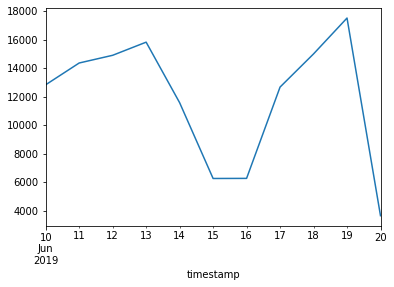

In [18]:
daily['repo'].plot()

## Estimate number of unique repositories

Expect the raw number of launches to be bigger than the number of repositories launched more than once. Those launched only once might have been accidents.

In [19]:
len(set(df.repo))

2816

In [20]:
len(set(df_.repo[df_.repo_counts>1]))

1771

## Where are repositories hosted?

In [21]:
(df.groupby("provider")
   .size()
   .reset_index(name='Launches')
   .sort_values('Launches', ascending=False))

,provider,Launches
2,GitHub,128067
0,Gist,1785
3,GitLab,709
1,Git,261
4,Zenodo,44


## Popular repositories and their branches

Ten most popular repos:

In [22]:
top20 = df.groupby("repo").count().sort_values("timestamp", ascending=False).head(20)
top20

,origin,provider,timestamp,org,ref
repo,,,,,
ipython/ipython-in-depth,43850,63927,63927,63927,63927
jupyterlab/jupyterlab-demo,9170,13178,13178,13178,13178
ines/spacy-io-binder,4371,6509,6509,6509,6509
DS-100/textbook,2587,3612,3612,3612,3612
bokeh/bokeh-notebooks,2152,3072,3072,3072,3072
ines/spacy-course,1349,1969,1969,1969,1969
binder-examples/r,1205,1694,1694,1694,1694
rationalmatter/juno-demo-notebooks,1170,1671,1671,1671,1671
binder-examples/requirements,1163,1608,1608,1608,1608


In [23]:
print("Cumulative top20 launches:", top20['ref'].sum())
print("The top20 repos are {:.2f}% of all "
      "launches.".format(100 * top20['ref'].sum() / df.shape[0]))

Cumulative top20 launches: 104850
The top20 repos are 80.12% of all launches.


In [24]:
(df_.groupby(["org", "repo", "ref", "repo_counts", "org_counts"])
 .size()
 # give the column a nice name
 .reset_index(name='ref_counts')
 # sort first by total launches, then within a repo by ref launches
 .sort_values(['org_counts', 'repo_counts', 'ref_counts'],
              ascending=[False,False, False])
 .set_index(["org", 'repo', 'ref'])
)

repo_counts  \
org                repo                                        ref                          
ipython            ipython/ipython-in-depth                    master               63927   
                   ipython/ipython                             6.x                     65   
                                                               master                  65   
jupyterlab         jupyterlab/jupyterlab-demo                  master               13178   
                   jupyterlab/jupyterlab-latex                 master                   5   
                   jupyterlab/jupyterlab                       master                   4   
                   jupyterlab/jupyterlab-data-explorer         master                   1   
ines               ines/spacy-io-binder                        live                  6509   
                                                               master                6509   
                   ines/spacy-course                           binder                1969   
                   ines/course-starter-python                  binder                  22   
                   ines/course-starter-r                       binder                  12   
                                                               master                  12   
binder-examples    binder-examples/r                           master                1694   
                   binder-examples/requirements                master                1608   
                                                               fa84f12               1608   
                   binder-examples/julia-python                master                 779   
                   binder-examples/matplotlib-versions         mpl-v2.0               207   
                                                               mpl-v1.5               207   
                   binder-examples/jupyter-stacks              master                 119   
                   binder-examples/python2_with_3              master                  82   
                   binder-examples/conda_environment           v1.0                    36   
                   binder-examples/jupyterlab                  master                  27   
                   binder-examples/bokeh                       master                  20   
                   binder-examples/jupyter-rise                master                  18   
                   binder-examples/multi-language-demo         master                  12   
                   binder-examples/appmode                     master                  11   
                   binder-examples/python-conda_pip            master                  10   
                   binder-examples/stencila-py                 master                   8   
                   binder-examples/minimal-dockerfile          truly-minimal            6   
...                                                                                   ...   
vincentarelbundock vincentarelbundock/Reinhart-Rogoff          master                   1   
vincentherrmann    vincentherrmann/time_frequency_analysis     master                   1   
vinci1it2000       vinci1it2000/formulas                       master                   1   
virtualzx-nad      virtualzx-nad/tutorial-test                 master                   1   
vishnuvrg          vishnuvrg/Data-Structures-and-Algorithms    master                   1   
vlad17             vlad17/TensorFlow-Learn                     master                   1   
voytekresearch     voytekresearch/fooof                        master                   1   
vsmolyakov         vsmolyakov/experiments_with_python          master                   1   
vstatkevich        vstatkevich/iab_google                      master                   1   
vsub21             vsub21/systemic-risk-dashboard              master                   1   
wdecoster          wdecoster/NanoPlot                          master          